In [1]:
!pip3 install diffusers

  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/dc/92/b17949ff6b634bfb93e12ff8753288d6c59edf4366cc5c501377e6373e0c/diffusers-0.24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.7 MB/s eta 0:00:0000:010:01


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


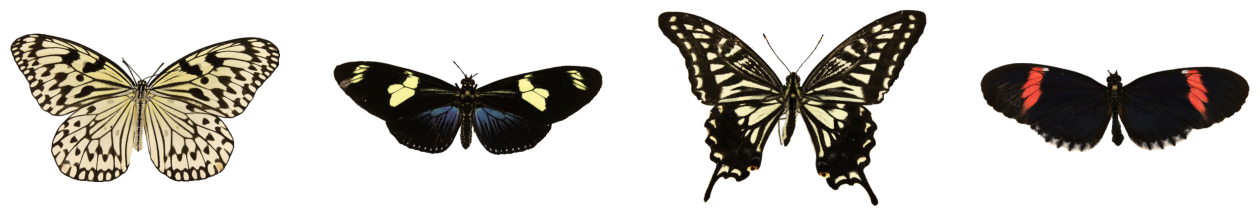

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [6]:
preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [8]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [10]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


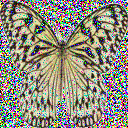

In [11]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0])

In [12]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 1: 0.0832
Train Learning Rate EPOCH: 1: 1.2600000000000001e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

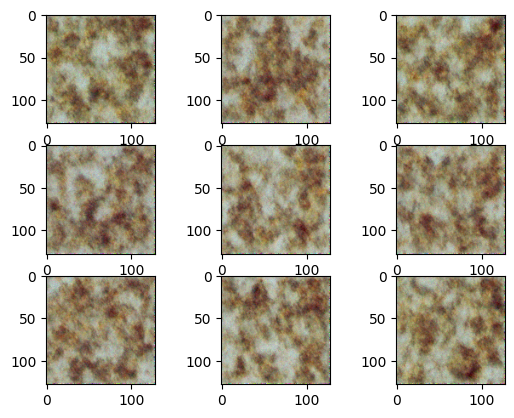

  2%|▏         | 1/50 [03:24<2:46:44, 204.17s/it]

------------------------------


  4%|▍         | 2/50 [04:13<1:30:35, 113.24s/it]

------------------------------
Train Loss EPOCH: 2: 0.0669
Train Learning Rate EPOCH: 2: 2.5200000000000003e-05
------------------------------


  6%|▌         | 3/50 [05:03<1:05:54, 84.15s/it] 

------------------------------
Train Loss EPOCH: 3: 0.0528
Train Learning Rate EPOCH: 3: 3.7800000000000004e-05
------------------------------


  8%|▊         | 4/50 [05:52<54:04, 70.53s/it]  

------------------------------
Train Loss EPOCH: 4: 0.0482
Train Learning Rate EPOCH: 4: 5.0400000000000005e-05
------------------------------


 10%|█         | 5/50 [06:42<47:13, 62.98s/it]

------------------------------
Train Loss EPOCH: 5: 0.0413
Train Learning Rate EPOCH: 5: 6.3e-05
------------------------------


 12%|█▏        | 6/50 [07:32<42:53, 58.49s/it]

------------------------------
Train Loss EPOCH: 6: 0.0374
Train Learning Rate EPOCH: 6: 7.560000000000001e-05
------------------------------


 14%|█▍        | 7/50 [08:21<39:49, 55.58s/it]

------------------------------
Train Loss EPOCH: 7: 0.0314
Train Learning Rate EPOCH: 7: 8.82e-05
------------------------------


 16%|█▌        | 8/50 [09:11<37:33, 53.65s/it]

------------------------------
Train Loss EPOCH: 8: 0.0285
Train Learning Rate EPOCH: 8: 9.999943783063545e-05
------------------------------


 18%|█▊        | 9/50 [10:01<35:48, 52.39s/it]

------------------------------
Train Loss EPOCH: 9: 0.0258
Train Learning Rate EPOCH: 9: 9.984235896746403e-05
------------------------------


 20%|██        | 10/50 [10:50<34:23, 51.58s/it]

------------------------------
Train Loss EPOCH: 10: 0.0216
Train Learning Rate EPOCH: 10: 9.940738186432565e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 11: 0.0220
Train Learning Rate EPOCH: 11: 9.869693175497514e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

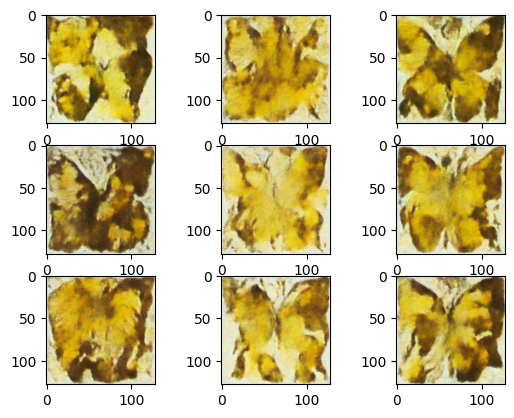

 22%|██▏       | 11/50 [14:15<1:03:53, 98.30s/it]

------------------------------


 24%|██▍       | 12/50 [15:04<52:53, 83.52s/it]  

------------------------------
Train Loss EPOCH: 12: 0.0260
Train Learning Rate EPOCH: 12: 9.771496978489323e-05
------------------------------


 26%|██▌       | 13/50 [15:54<45:11, 73.29s/it]

------------------------------
Train Loss EPOCH: 13: 0.0239
Train Learning Rate EPOCH: 13: 9.646697092574766e-05
------------------------------


 28%|██▊       | 14/50 [16:44<39:41, 66.14s/it]

------------------------------
Train Loss EPOCH: 14: 0.0238
Train Learning Rate EPOCH: 14: 9.495989344945056e-05
------------------------------


 30%|███       | 15/50 [17:33<35:40, 61.17s/it]

------------------------------
Train Loss EPOCH: 15: 0.0218
Train Learning Rate EPOCH: 15: 9.320214013201078e-05
------------------------------


 32%|███▏      | 16/50 [18:23<32:45, 57.80s/it]

------------------------------
Train Loss EPOCH: 16: 0.0216
Train Learning Rate EPOCH: 16: 9.120351140349089e-05
------------------------------


 34%|███▍      | 17/50 [19:13<30:27, 55.38s/it]

------------------------------
Train Loss EPOCH: 17: 0.0200
Train Learning Rate EPOCH: 17: 8.897515070528305e-05
------------------------------


 36%|███▌      | 18/50 [20:03<28:37, 53.68s/it]

------------------------------
Train Loss EPOCH: 18: 0.0192
Train Learning Rate EPOCH: 18: 8.652948235936705e-05
------------------------------


 38%|███▊      | 19/50 [20:52<27:06, 52.45s/it]

------------------------------
Train Loss EPOCH: 19: 0.0183
Train Learning Rate EPOCH: 19: 8.388014229596275e-05
------------------------------


 40%|████      | 20/50 [21:42<25:47, 51.59s/it]

------------------------------
Train Loss EPOCH: 20: 0.0159
Train Learning Rate EPOCH: 20: 8.104190202580812e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

------------------------------
Train Loss EPOCH: 21: 0.0169
Train Learning Rate EPOCH: 21: 7.803058628095877e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

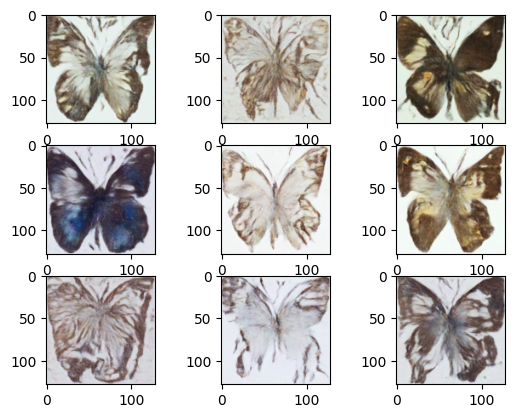

 42%|████▏     | 21/50 [25:06<47:03, 97.35s/it]

------------------------------


 44%|████▍     | 22/50 [25:56<38:45, 83.04s/it]

------------------------------
Train Loss EPOCH: 22: 0.0207
Train Learning Rate EPOCH: 22: 7.486298478330615e-05
------------------------------


 46%|████▌     | 23/50 [26:45<32:50, 73.00s/it]

------------------------------
Train Loss EPOCH: 23: 0.0190
Train Learning Rate EPOCH: 23: 7.155675863275306e-05
------------------------------


 48%|████▊     | 24/50 [27:35<28:35, 65.98s/it]

------------------------------
Train Loss EPOCH: 24: 0.0195
Train Learning Rate EPOCH: 24: 6.813034183698301e-05
------------------------------


 50%|█████     | 25/50 [28:24<25:25, 61.04s/it]

------------------------------
Train Loss EPOCH: 25: 0.0186
Train Learning Rate EPOCH: 25: 6.460283853184879e-05
------------------------------


 52%|█████▏    | 26/50 [29:14<23:02, 57.61s/it]

------------------------------
Train Loss EPOCH: 26: 0.0185
Train Learning Rate EPOCH: 26: 6.0993916465432213e-05
------------------------------


 54%|█████▍    | 27/50 [30:04<21:09, 55.21s/it]

------------------------------
Train Loss EPOCH: 27: 0.0175
Train Learning Rate EPOCH: 27: 5.732369733965931e-05
------------------------------


 56%|█████▌    | 28/50 [30:53<19:39, 53.62s/it]

------------------------------
Train Loss EPOCH: 28: 0.0169
Train Learning Rate EPOCH: 28: 5.361264462087627e-05
------------------------------


 58%|█████▊    | 29/50 [31:43<18:23, 52.53s/it]

------------------------------
Train Loss EPOCH: 29: 0.0161
Train Learning Rate EPOCH: 29: 4.9881449444902904e-05
------------------------------


 60%|██████    | 30/50 [32:33<17:15, 51.78s/it]

------------------------------
Train Loss EPOCH: 30: 0.0139
Train Learning Rate EPOCH: 30: 4.615091525270501e-05
------------------------------


100%|██████████| 63/63 [00:50<00:00,  1.26it/s]

------------------------------
Train Loss EPOCH: 31: 0.0148
Train Learning Rate EPOCH: 31: 4.244184179990459e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

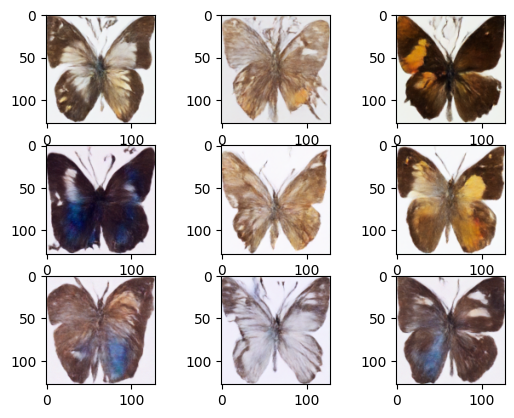

 62%|██████▏   | 31/50 [35:59<30:58, 97.79s/it]

------------------------------


 64%|██████▍   | 32/50 [36:48<25:01, 83.41s/it]

------------------------------
Train Loss EPOCH: 32: 0.0183
Train Learning Rate EPOCH: 32: 3.87749091868379e-05
------------------------------


 66%|██████▌   | 33/50 [37:38<20:47, 73.36s/it]

------------------------------
Train Loss EPOCH: 33: 0.0170
Train Learning Rate EPOCH: 33: 3.517056255575659e-05
------------------------------


 68%|██████▊   | 34/50 [38:28<17:42, 66.38s/it]

------------------------------
Train Loss EPOCH: 34: 0.0177
Train Learning Rate EPOCH: 34: 3.164889809804808e-05
------------------------------


 70%|███████   | 35/50 [39:19<15:22, 61.51s/it]

------------------------------
Train Loss EPOCH: 35: 0.0167
Train Learning Rate EPOCH: 35: 2.822955100704634e-05
------------------------------


 72%|███████▏  | 36/50 [40:09<13:32, 58.06s/it]

------------------------------
Train Loss EPOCH: 36: 0.0166
Train Learning Rate EPOCH: 36: 2.4931586001157835e-05
------------------------------


 74%|███████▍  | 37/50 [40:58<12:02, 55.60s/it]

------------------------------
Train Loss EPOCH: 37: 0.0159
Train Learning Rate EPOCH: 37: 2.1773391027694734e-05
------------------------------


 76%|███████▌  | 38/50 [41:48<10:46, 53.91s/it]

------------------------------
Train Loss EPOCH: 38: 0.0155
Train Learning Rate EPOCH: 38: 1.877257474007511e-05
------------------------------


 78%|███████▊  | 39/50 [42:38<09:39, 52.71s/it]

------------------------------
Train Loss EPOCH: 39: 0.0150
Train Learning Rate EPOCH: 39: 1.5945868320010076e-05
------------------------------


 80%|████████  | 40/50 [43:28<08:38, 51.83s/it]

------------------------------
Train Loss EPOCH: 40: 0.0129
Train Learning Rate EPOCH: 40: 1.3309032192072463e-05
------------------------------


100%|██████████| 63/63 [00:49<00:00,  1.26it/s]

------------------------------
Train Loss EPOCH: 41: 0.0137
Train Learning Rate EPOCH: 41: 1.0876768150764277e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

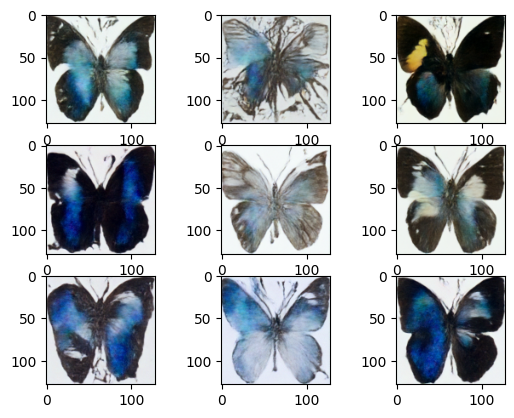

 82%|████████▏ | 41/50 [46:53<14:40, 97.83s/it]

------------------------------


 84%|████████▍ | 42/50 [47:43<11:07, 83.48s/it]

------------------------------
Train Loss EPOCH: 42: 0.0170
Train Learning Rate EPOCH: 42: 8.66263739002211e-06
------------------------------


 86%|████████▌ | 43/50 [48:33<08:33, 73.41s/it]

------------------------------
Train Loss EPOCH: 43: 0.0159
Train Learning Rate EPOCH: 43: 6.678984892190559e-06
------------------------------


 88%|████████▊ | 44/50 [49:23<06:38, 66.34s/it]

------------------------------
Train Loss EPOCH: 44: 0.0166
Train Learning Rate EPOCH: 44: 4.9368705980363415e-06
------------------------------


 90%|█████████ | 45/50 [50:13<05:06, 61.38s/it]

------------------------------
Train Loss EPOCH: 45: 0.0158
Train Learning Rate EPOCH: 45: 3.4460077415675474e-06
------------------------------


 92%|█████████▏| 46/50 [51:03<03:51, 57.92s/it]

------------------------------
Train Loss EPOCH: 46: 0.0154
Train Learning Rate EPOCH: 46: 2.214708693475065e-06
------------------------------


 94%|█████████▍| 47/50 [51:53<02:46, 55.50s/it]

------------------------------
Train Loss EPOCH: 47: 0.0152
Train Learning Rate EPOCH: 47: 1.2498386151482467e-06
------------------------------


 96%|█████████▌| 48/50 [52:42<01:47, 53.83s/it]

------------------------------
Train Loss EPOCH: 48: 0.0149
Train Learning Rate EPOCH: 48: 5.567771816690381e-07
------------------------------


 98%|█████████▊| 49/50 [53:33<00:52, 52.69s/it]

------------------------------
Train Loss EPOCH: 49: 0.0144
Train Learning Rate EPOCH: 49: 1.3938858719967363e-07
------------------------------


100%|██████████| 50/50 [54:22<00:00, 65.26s/it]

------------------------------
Train Loss EPOCH: 50: 0.0124
Train Learning Rate EPOCH: 50: 0.0
------------------------------
Training Time: 3262.83s


In [16]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

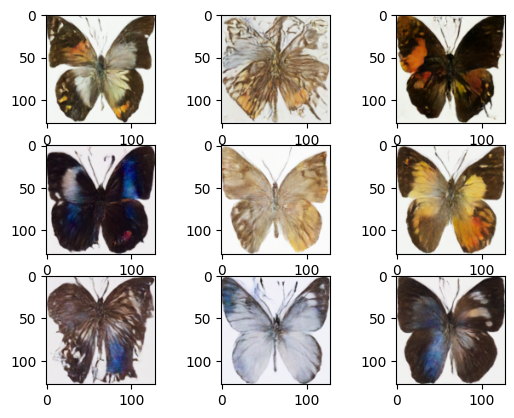

In [17]:
sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)